In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.utils import resample

In [29]:
def merge_tables(_pit: pd.DataFrame, _results: pd.DataFrame, _status: pd.DataFrame) -> pd.DataFrame:
    """
    merges the data files
    :param _pit:
    :param _results:
    :param _status:
    :return:
    """
    _select_col = ['raceId','driverId','positionOrder', 'laps', 'time','statusId']
    mg_df = pd.merge(_pit, _results[_select_col], on=['raceId','driverId'], how = 'left', suffixes=('_pit', '_result'))
    mg_df = pd.merge(mg_df, _status, on='statusId', how='left')

    _status_select = [1, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    mg_df.drop(mg_df[~mg_df['statusId'].isin(_status_select)].index, inplace=True)
    return mg_df


def process_laps_stops(mg_df: pd.DataFrame) -> pd.DataFrame:
    _total_laps = mg_df[(mg_df['positionOrder'] == 1) & (mg_df['stop'] == 1)].reset_index(drop=True)[['raceId', 'laps']]
    _total_laps.columns = [str(_total_laps.columns[0]), 'total_laps']
    _total_stops = mg_df.groupby(by=['raceId', 'driverId'], as_index=False)['stop'].max()
    _total_stops.columns = list(_total_stops.columns[:2]) + ['total_stops']

    mg_df = pd.merge(mg_df, _total_laps, on='raceId')
    mg_df = pd.merge(mg_df, _total_stops, on=['raceId', 'driverId'])
    mg_df['lap_prop'] = mg_df.apply(lambda x: x['lap']/x['total_laps'], axis=1)

    return mg_df


def group_by_stop_num(df: pd.DataFrame) -> dict:
    pit_stop_max = df['total_stops'].max()
    _df_dict = {}
    for i in range(1, pit_stop_max+1):
        _df_dict[i] = df[df['total_stops']==i][['stop','lap_prop']]
    return _df_dict


def comparison_plot(list_1: [pd.DataFrame], list_2: [pd.DataFrame],
                    show_mean=True, show_description=True, save_fig=False):
    """
    d
    :param list_1:
    :param list_2:
    :param save_fig:
    :param show_description:
    :param show_mean:
    :return:
    """
    bins = np.linspace(0,1,50)
    color_bin = ['tab:blue', 'tab:orange', 'tab:red']
    color_bin2 = ['cyan', 'yellow', 'lavender']

    plot_index = [[1,1], [2,1], [2,2], [3,1], [3,2], [3,3]]
    plot_num = 6

    for _i in range(plot_num):
        df_f = list_1[_i]['lap_prop']  # front
        df_b = resample(list_2[_i]['lap_prop'],
                        replace=True, n_samples=len(df_f), random_state=1)  # back
        plt.figure(figsize=(12,6))
        plt.hist(df_b, bins, alpha=0.8, color=color_bin[1])
        plt.hist(df_f, bins, alpha=0.8, color=color_bin[0])
        df_f_mean = round(df_f.mean(), ndigits=3)
        df_b_mean = round(df_b.mean(), ndigits=3)
        plt.axvline(x=df_f_mean, color=color_bin2[0])
        plt.axvline(x=df_b_mean, color=color_bin2[1])
        plt.show()

In [30]:
# Load data
pit = pd.read_csv('data/pit_stops.csv')
results = pd.read_csv('data/results.csv')
status = pd.read_csv('data/status.csv')

In [31]:
# Process the data files
merge_df = merge_tables(pit, results, status)
merge_df = process_laps_stops(merge_df)

In [32]:
max_pit = 3
top_num = 4
df_front = []
df_back = []

for i in range(1, max_pit+1):
    df_tmp = merge_df[merge_df['total_stops']==i]
    for j in range(1, i+1):
        df_select = df_tmp[df_tmp['stop']==j]
        df_front.append(df_select[df_select['positionOrder'] <= top_num][['stop', 'lap_prop']])
        df_back.append(df_select[df_select['positionOrder'] > top_num][['stop', 'lap_prop']])

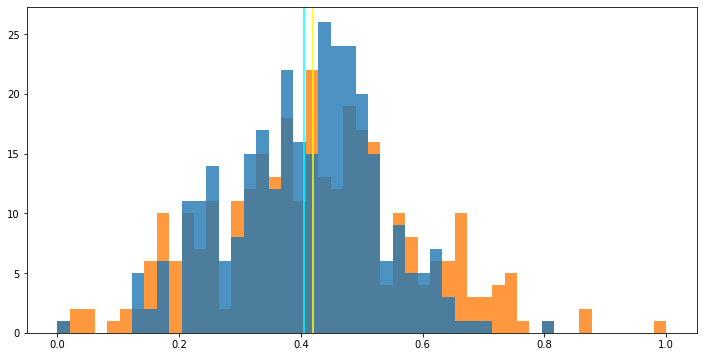

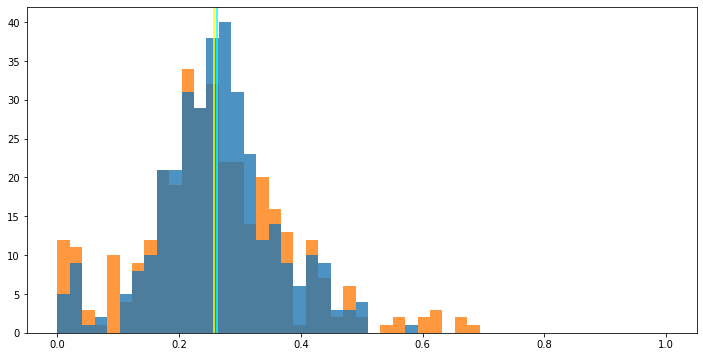

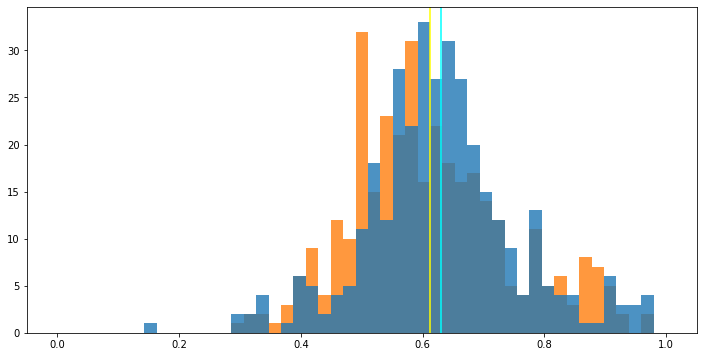

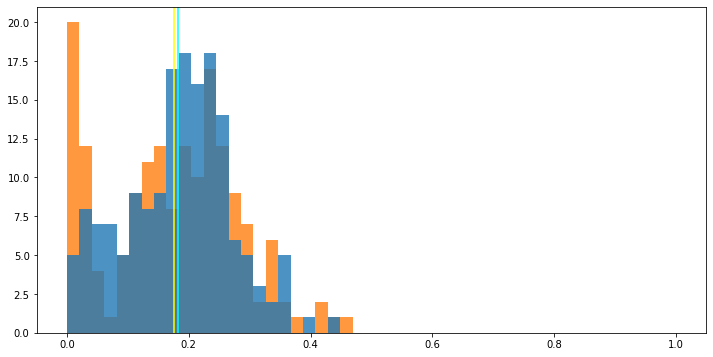

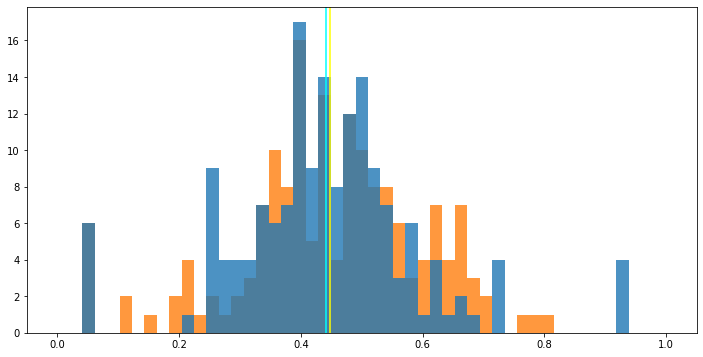

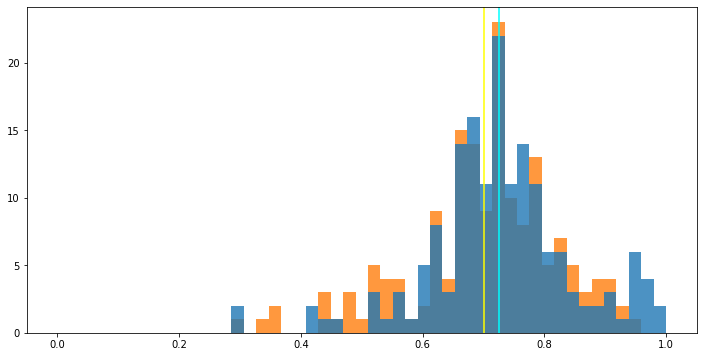

In [33]:
comparison_plot(df_front, df_back)